# Models

In [6]:
import pandas as pd
import numpy as np

PATH_FINAL = '../../data/final/'

In [7]:
students = pd.read_csv(PATH_FINAL+'students.csv', index_col=0)
doctors = pd.read_csv(PATH_FINAL+'doctors_all.csv', index_col=0)
nrpzs = pd.read_csv(PATH_FINAL+'nrpzs.csv', index_col=0)
demographics = pd.read_csv(PATH_FINAL+'demographics.csv', index_col=0)
insurances = pd.read_csv(PATH_FINAL+'insurances.csv', index_col=0)
dentists_age_estimate = pd.read_csv(PATH_FINAL+'dentists_age_estimate.csv', index_col=0)

/home/gary/Apps/miniconda3/envs/vzd/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (0,3,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/gary/Apps/miniconda3/envs/vzd/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1. Graduated students estimate 

In [100]:
students_start_count = students.reset_index().groupby(['date_start', 'university', 'degree']).count()[['index']].reset_index()
students_start_count = students_start_count[(2022 > students_start_count.date_start) & (students_start_count.date_start > 2010)]
total_sum = students_start_count.groupby(['date_start', 'university']).sum().reset_index()
total_sum.columns = ['date_start', 'university', 'total']
merged_students = pd.merge(students_start_count, total_sum)
merged_students['mudr_ratio'] = merged_students['index']/merged_students['total']
merged_students = merged_students[merged_students.degree =='MUDr.'][['date_start', 'university', 'mudr_ratio']]
merged_students.loc[len(merged_students.index)] = [2020, 'OVA', 1.] 

In [101]:
uni_codes = {
    '11110': '1LFUK',
    '11120': '2LFUK',
    '11130': '3LFUK',
    '11140': 'PLUK',
    '11150': 'HKUK',
    '14110': 'MUNI',
    '15110': 'UPOL',
    '17110': 'OVA'
}

# uspesnosti https://www.ceskovdatech.cz/graphs/vs2.php
chance_to_graduate = {
    '1LFUK': .599,
    '2LFUK': .789,
    '3LFUK': .62,
    'PLUK': .758,
    'HKUK': .725,
    'MUNI': .648,
    'UPOL': .789,
    'OVA': .782 
}

new_students = dict()
graduate_estimate = dict()

all_tables = pd.DataFrame()
# https://dsia.msmt.cz//vystupy.html
for year in range(10, 22):
    table = pd.read_html(f'https://dsia.msmt.cz//vysluch{year}.html')[0]
    table.columns = table.iloc[0]
    table = table[1:][['rid','název školy/fakulty', 'zapsaných']].rename(columns={'zapsaných': 'count'})
    table = table[table['název školy/fakulty'].str.contains('ékařská')]
    table['university'] = table['rid'].apply(lambda x: uni_codes[x])
    table = table[['university', 'count']]
    table['date_start'] = 2000+year
    table['count'] = pd.to_numeric(table['count'])
    # table['graduate_estimate'] = round(table['zapsaných'].apply(int) * table['uni'].apply(lambda x: chance_to_graduate[x]))
    all_tables = all_tables.append(table)

In [102]:
graduates_estimate = pd.merge(all_tables, merged_students)
graduates_estimate['mudr'] = round(graduates_estimate['mudr_ratio']*graduates_estimate['count'])
graduates_estimate['mddr'] = round((1-graduates_estimate['mudr_ratio'])*graduates_estimate['count'])
graduates_estimate['mudr_graduate_estimate'] = round(graduates_estimate['mudr'].apply(int) * graduates_estimate['university'].apply(lambda x: chance_to_graduate[x]))
graduates_estimate['mddr_graduate_estimate'] = round(graduates_estimate['mddr'].apply(int) * graduates_estimate['university'].apply(lambda x: chance_to_graduate[x]))

mudr_estimates = graduates_estimate.groupby('date_start').sum()[['mudr_graduate_estimate']].reset_index()
mddr_estimates = graduates_estimate.groupby('date_start').sum()[['mddr_graduate_estimate']].reset_index()

mudr_estimates['date_end'] = mudr_estimates['date_start'] + 6
mddr_estimates['date_end'] = mddr_estimates['date_start'] + 5

mudr_dict = pd.Series(mudr_estimates.mudr_graduate_estimate.values,index=mudr_estimates.index+6).to_dict()
mddr_dict = pd.Series(mddr_estimates.mddr_graduate_estimate.values,index=mddr_estimates.index+5).to_dict()

In [103]:
# mudr_estimates.reindex(mudr_estimates.index + 6)
# mddr_estimates.reindex(mddr_estimates.index + 5)
mudr_estimates['mudr_graduate_estimate_all'] = mudr_estimates['mudr_graduate_estimate']//60*100
mddr_estimates['mddr_graduate_estimate_all'] = mddr_estimates['mddr_graduate_estimate']//60*100

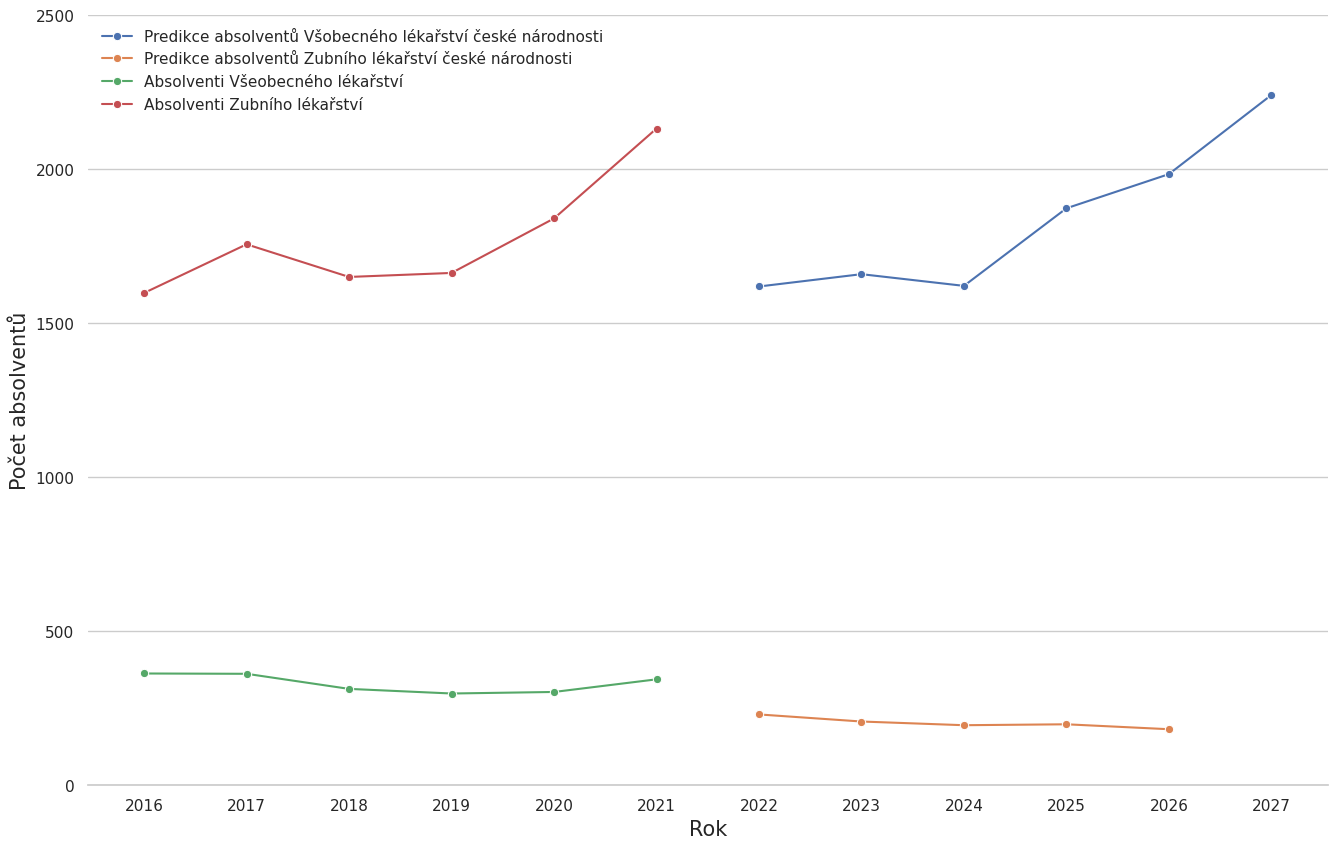

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("whitegrid")

ax = sns.lineplot(data=mudr_estimates[mudr_estimates.date_end > 2021], x='date_end', y='mudr_graduate_estimate', marker="o", label='Predikce absolventů Všobecného lékařství české národnosti')    
sns.lineplot(data=mddr_estimates[mddr_estimates.date_end > 2021], x='date_end', y='mddr_graduate_estimate', marker="o", label='Predikce absolventů Zubního lékařství české národnosti')    


grads = students[(students.date_end > 2015) & (students.date_end < 2022)].groupby(['date_end','degree']).count()[['age_end']]
grads.columns = ['count']
grads = grads.reset_index()

sns.lineplot(data=grads[grads['degree'] == 'MDDr.'], x='date_end', y='count', marker="o", label='Absolventi Všeobecného lékařství')  
sns.lineplot(data=grads[grads['degree'] == 'MUDr.'], x='date_end', y='count', marker="o", label='Absolventi Zubního lékařství')  

ax.yaxis.grid(True)
ax.xaxis.grid(False)
sns.despine(left = True)

plt.xticks(range(2016, 2028))
plt.ylim(-1, 2500)

# plt.title(title, fontweight="bold")
plt.xlabel('Rok', fontsize=15)
plt.ylabel('Počet absolventů', fontsize=15)
plt.legend(frameon=False)
plt.show();


In [137]:
print('Pocet lekaru mezi 60-65 lety:')
tmp = doctors[(doctors.age_estimate >= 60) & (doctors.age_estimate <= 65) & (doctors.doctor_url.str.contains('lkcr'))].reset_index().drop_duplicates('_id')
mudr_retired = tmp.age_estimate.value_counts().sort_index().reset_index()
mudr_retired.columns = ['age', 'count']
mudr_retired['year'] = 2022 + (65-mudr_retired['age'])
mudr_retired

Pocet lekaru mezi 60-65 lety:


,age,count,year
0,60.0,873,2027.0
1,61.0,925,2026.0
2,62.0,1109,2025.0
3,63.0,1079,2024.0
4,64.0,1105,2023.0
5,65.0,1058,2022.0


In [133]:
print('Nejvice postizene okresy:')
tmp = doctors[(doctors.age_estimate >= 60) & (doctors.age_estimate <= 65) & (doctors.doctor_url.str.contains('lkcr'))].reset_index().drop_duplicates('_id')
tmp_all = doctors[(doctors.doctor_url.str.contains('lkcr'))].reset_index().drop_duplicates('_id')
tmp = tmp.district.value_counts().reset_index()
tmp_all = tmp_all.district.value_counts().reset_index()
tmp_merge = pd.merge(tmp_all, tmp, on='index', suffixes=('_total', '_o60'))
tmp_merge['perc'] = (100 * tmp_merge['district_o60'] / tmp_merge['district_total']).apply(lambda x: round(x, 2))
display(tmp_merge.sort_values('perc').head())

Nejvice postizene okresy:


,index,district_total,district_o60,perc
41,Benešov,332,29,8.73
11,Liberec,694,61,8.79
38,Kolín,342,31,9.06
2,Ostrava-město,1994,186,9.33
53,Klatovy,282,27,9.57


In [139]:
mudr_future = mudr_estimates[mudr_estimates['date_end'] > 2021][['date_end', 'mudr_graduate_estimate']]
mudr_future.columns = ['year', 'count']
mudr_pred = pd.merge(mudr_retired, mudr_future, on='year', suffixes=('_retired', '_graduated'))
mudr_pred['ratio'] = mudr_pred['count_retired'] / mudr_pred['count_graduated']

,age,count_retired,year,count_graduated,ratio
0,60.0,873,2027.0,2241.0,0.389558
1,61.0,925,2026.0,1984.0,0.466230
2,62.0,1109,2025.0,1873.0,0.592098
3,63.0,1079,2024.0,1621.0,0.665638
4,64.0,1105,2023.0,1659.0,0.666064
5,65.0,1058,2022.0,1619.0,0.653490


No handles with labels found to put in legend.


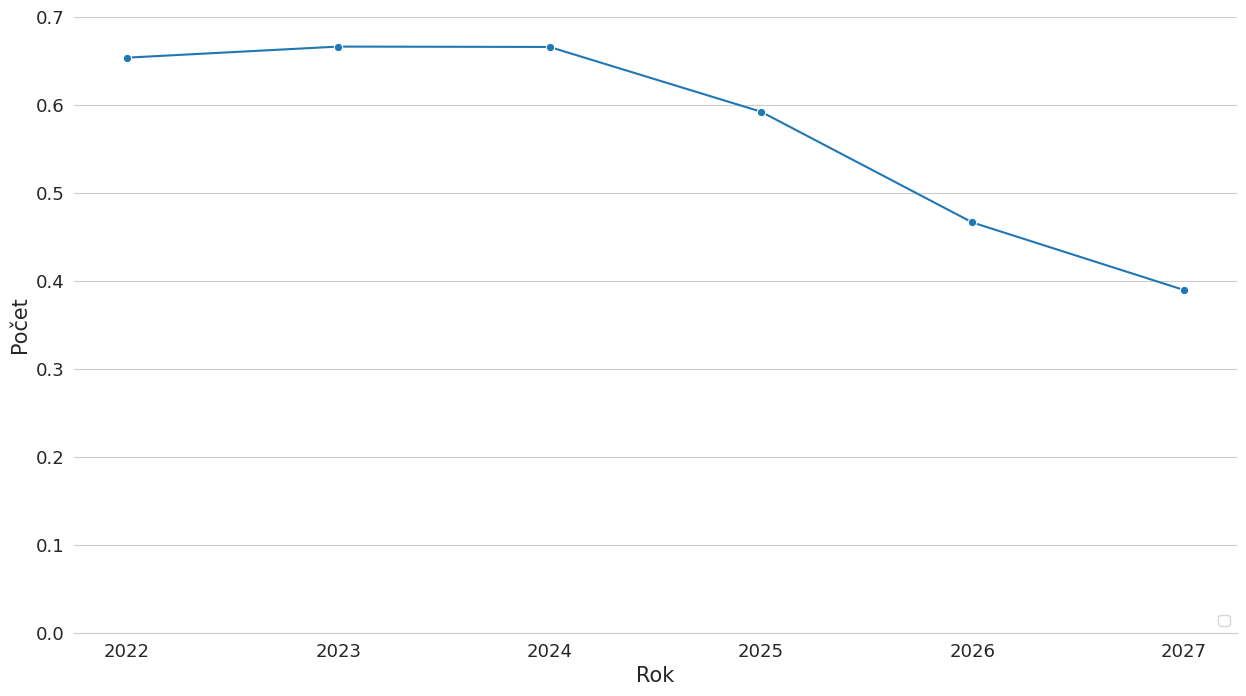

In [167]:
sns.set_style('whitegrid')

plt.figure(figsize=(15, 8))
plt.grid(False, axis='x')

sns.lineplot(x=mudr_pred['year'], y=mudr_pred['ratio'], marker='o')


sns.despine(left = True)

plt.xticks(range(2022,2028), fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0, .70)

ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines


# plt.title('Všeobecné lékařsví a ČLK')
plt.xlabel('Rok', fontsize=15)
plt.ylabel('Počet', fontsize=15)
plt.legend(loc='lower right')
plt.show();



## 2. Sampling

### 2.1 Gender ratio + age ratio comparison (VZP vs OZP)

In [8]:
ozp_age = pd.DataFrame([['0-4' , 46954],
                        ['5-9' , 56106],
                        ['10-14' , 49108],
                        ['15-19' , 37875],
                        ['20-24' , 40677],
                        ['25-29' , 45360],
                        ['30-34' , 45078],
                        ['35-39' , 60355],
                        ['40-44' , 68391],
                        ['45-49' , 51373],
                        ['50-54' , 46041],
                        ['55-59' , 39073],
                        ['60-64' , 43430],
                        ['65-69' , 41009],
                        ['70-74' , 28511],
                        ['75-79' , 15206],
                        ['80-84' , 7901],
                        ['85+' , 3957+1247+139],
                        ['Celkem' , 727791]], columns=['age', 'count'])

ozp_age['ratio'] = ozp_age['count'] / 727791
ozp_age

,age,count,ratio
0,0-4,46954,0.064516
1,5-9,56106,0.077091
2,10-14,49108,0.067475
3,15-19,37875,0.052041
4,20-24,40677,0.055891
5,25-29,45360,0.062326
6,30-34,45078,0.061938
7,35-39,60355,0.082929
8,40-44,68391,0.093971
9,45-49,51373,0.070588


In [9]:
vzp_age = pd.read_excel('../../data/raw/ic/rocenka_vzp_2021.xlsx', sheet_name='I_T 1.3')
vzp_age = vzp_age.iloc[6:].reset_index(drop=True)
vzp_age.columns = ['age', 'male', 'female', 'count', 'male_ratio', 'female_ratio']
vzp_age.age = vzp_age.age.replace('–', '-')
vzp_age['ratio'] = vzp_age['count'] / 5914857

In [10]:
ratios = pd.merge(vzp_age[['age', 'ratio', 'count']], ozp_age[['age', 'ratio', 'count']], on='age', suffixes=('_vzp', '_ozp'))
ratios['difference'] = ratios['ratio_vzp'] - ratios['ratio_ozp']
ratios['count_ozp_mult'] = ratios['count_ozp'] *( 5914857 // 727791)
ratios


,age,ratio_vzp,count_vzp,ratio_ozp,count_ozp,difference,count_ozp_mult
0,0-4,0.0500957,296309,0.064516,46954,-0.0144201,375632
1,5-9,0.0480548,284237,0.077091,56106,-0.0290361,448848
2,10-14,0.0481352,284713,0.067475,49108,-0.0193402,392864
3,15-19,0.040765,241119,0.052041,37875,-0.0112761,303000
4,20-24,0.041566,245857,0.055891,40677,-0.014325,325416
5,25-29,0.0555628,328646,0.062326,45360,-0.00676279,362880
6,30-34,0.066699,394515,0.061938,45078,0.00476088,360624
7,35-39,0.069121,408841,0.082929,60355,-0.013808,482840
8,40-44,0.0773123,457291,0.093971,68391,-0.0166584,547128
9,45-49,0.0788034,466111,0.070588,51373,0.00821585,410984


In [268]:
print('Female / Male ratio OZP: 0.55 : 0.45 (50:50 until 30 y)') # https://www.ozp.cz/web/files-c/510/vz_ozp_2011_working.pdf, https://www.ozp.cz/web/files-c/510/vz_ozp_2010_working.pdf
print('Female / Male ratio VZP: 0.50 : 0.50 (46:54 between 30-55 y)') # see rocenka_vzp_2021.xlsx
print('OZP has younger customers that VZP until 45 y (by ratios)') # see previous table (difference)

Female / Male ratio OZP: 0.55 : 0.45 (50:50 until 30 y)
Female / Male ratio VZP: 0.50 : 0.50 (46:54 between 30-55 y)
OZP has younger customers that VZP until 45 y (by ratios)


### 2.2 Geographic comparison (VZP)

In [31]:
vzp_demo = pd.read_excel('../../data/raw/ic/rocenka_vzp_2021.xlsx', sheet_name='I_T 1.1')
vzp_demo = vzp_demo.iloc[6:].reset_index(drop=True)
vzp_demo.columns = ['area', 'male', 'female', 'count', 'male_ratio', 'female_ratio']
vzp_demo['ratio'] = vzp_demo['count'] / 5914857
vzp_demo

,area,male,female,count,male_ratio,female_ratio,ratio
0,Hlavní město Praha,454498,428197,882695,51.5,48.5,0.149234
1,Středočeský kraj,349405,338373,687778,50.8,49.2,0.11628
2,Jihočeský kraj,188302,193132,381434,49.4,50.6,0.0644874
3,Plzeňský kraj,160844,162695,323539,49.7,50.3,0.0546994
4,Karlovarský kraj,87212,91134,178346,48.9,51.1,0.0301522
5,Ústecký kraj,262455,267780,530235,49.5,50.5,0.0896446
6,Liberecký kraj,157750,164022,321772,49,51,0.0544006
7,Královéhradecký kraj,154680,155674,310354,49.8,50.2,0.0524702
8,Pardubický kraj,172000,175677,347677,49.5,50.5,0.0587803
9,Kraj Vysočina,181386,181611,362997,50,50,0.0613704


In [32]:
# https://www.czso.cz/csu/scitani2021/vekova-struktura
demo = pd.read_excel('../../data/raw/sldb2021_obyvatelstvo.xlsx', sheet_name='Tab._3')
demo = demo.drop(columns=[col for col in demo.columns if 'Unnamed: 0' in col])
demo = demo[demo.columns[:4]]
demo.columns = ['area', 'count', 'male', 'female']
demo = demo.iloc[5:-1].reset_index(drop=True)
demo[demo.columns[1:]] = demo[demo.columns[1:]].applymap(int)
demo.loc[demo.shape[0]] = demo.sum(numeric_only=True, axis=0)
demo.loc[demo.shape[0]-1, 'area'] = 'Celkem'

demo['male_ratio'] = (100 * demo['male'] / demo['count']).apply(lambda n: round(n, 1))
demo['female_ratio'] = (100 * demo['female'] / demo['count']).apply(lambda n: round(n, 1))
demo['ratio'] = (demo['count'] / 10524167).apply(lambda n: round(n, 3))
demo

,area,count,male,female,male_ratio,female_ratio,ratio
0,Hlavní město Praha,1301432.0,633449.0,667983.0,48.7,51.3,0.124
1,Středočeský kraj,1415463.0,702541.0,712922.0,49.6,50.4,0.134
2,Jihočeský kraj,631803.0,312168.0,319635.0,49.4,50.6,0.060
3,Plzeňský kraj,581436.0,288879.0,292557.0,49.7,50.3,0.055
4,Karlovarský kraj,279103.0,138110.0,140993.0,49.5,50.5,0.027
5,Ústecký kraj,789098.0,388965.0,400133.0,49.3,50.7,0.075
6,Liberecký kraj,435220.0,215420.0,219800.0,49.5,50.5,0.041
7,Královéhradecký kraj,538303.0,266017.0,272286.0,49.4,50.6,0.051
8,Pardubický kraj,510037.0,252946.0,257091.0,49.6,50.4,0.048
9,Kraj Vysočina,497661.0,247368.0,250293.0,49.7,50.3,0.047


In [33]:
total_demo = pd.merge(demo, vzp_demo, on='area', suffixes=('', '_vzp'))

for col in total_demo.columns[1:7]:
    total_demo[col+'_diff'] = total_demo[col] - total_demo[col+'_vzp']
    total_demo[col+'_diff'] = total_demo[col+'_diff'].apply(lambda n: round(n, 3))
total_demo

,area,count,male,female,male_ratio,female_ratio,ratio,male_vzp,female_vzp,count_vzp,male_ratio_vzp,female_ratio_vzp,ratio_vzp,count_diff,male_diff,female_diff,male_ratio_diff,female_ratio_diff,ratio_diff
0,Hlavní město Praha,1301432.0,633449.0,667983.0,48.7,51.3,0.124,454498,428197,882695,51.5,48.5,0.149234,418737.0,178951.0,239786.0,-2.8,2.8,-0.025
1,Středočeský kraj,1415463.0,702541.0,712922.0,49.6,50.4,0.134,349405,338373,687778,50.8,49.2,0.11628,727685.0,353136.0,374549.0,-1.2,1.2,0.018
2,Jihočeský kraj,631803.0,312168.0,319635.0,49.4,50.6,0.060,188302,193132,381434,49.4,50.6,0.0644874,250369.0,123866.0,126503.0,0.0,0.0,-0.004
3,Plzeňský kraj,581436.0,288879.0,292557.0,49.7,50.3,0.055,160844,162695,323539,49.7,50.3,0.0546994,257897.0,128035.0,129862.0,0.0,0.0,0.000
4,Karlovarský kraj,279103.0,138110.0,140993.0,49.5,50.5,0.027,87212,91134,178346,48.9,51.1,0.0301522,100757.0,50898.0,49859.0,0.6,-0.6,-0.003
5,Ústecký kraj,789098.0,388965.0,400133.0,49.3,50.7,0.075,262455,267780,530235,49.5,50.5,0.0896446,258863.0,126510.0,132353.0,-0.2,0.2,-0.015
6,Liberecký kraj,435220.0,215420.0,219800.0,49.5,50.5,0.041,157750,164022,321772,49,51,0.0544006,113448.0,57670.0,55778.0,0.5,-0.5,-0.013
7,Královéhradecký kraj,538303.0,266017.0,272286.0,49.4,50.6,0.051,154680,155674,310354,49.8,50.2,0.0524702,227949.0,111337.0,116612.0,-0.4,0.4,-0.001
8,Pardubický kraj,510037.0,252946.0,257091.0,49.6,50.4,0.048,172000,175677,347677,49.5,50.5,0.0587803,162360.0,80946.0,81414.0,0.1,-0.1,-0.011
9,Kraj Vysočina,497661.0,247368.0,250293.0,49.7,50.3,0.047,181386,181611,362997,50,50,0.0613704,134664.0,65982.0,68682.0,-0.3,0.3,-0.014


In [34]:
total_demo[['area', 'count', 'count_vzp', 'male_ratio_diff','female_ratio_diff','ratio_diff']]

np.corrcoef(total_demo['count'].to_numpy(), total_demo['count_vzp'].apply(int).to_numpy())

array([[1.        , 0.99713437],
       [0.99713437, 1.        ]])

### 2.2.1 Area + Gender comparison

In [45]:
demo['male_ratio_total'] = (demo['ratio']*demo['male_ratio']/100).apply(lambda x: round(x, 3))
demo['female_ratio_total'] = (demo['ratio']*demo['female_ratio']/100).apply(lambda x: round(x, 3))

fr_total = demo[['area', 'female_ratio_total']].rename(columns={'female_ratio_total': 'ratio_total'})
fr_total['label'] = 'Ženy - celkem'
mr_total = demo[['area', 'male_ratio_total']].rename(columns={'male_ratio_total': 'ratio_total'})
mr_total['label'] = 'Muži - celkem'

vzp_demo['female_ratio_total'] = (vzp_demo['ratio']*vzp_demo['female_ratio']/100).apply(lambda x: round(x, 3))
vzp_demo['male_ratio_total'] = (vzp_demo['ratio']*vzp_demo['male_ratio']/100).apply(lambda x: round(x, 3))

fr_total_vzp = vzp_demo[['area', 'female_ratio_total']].rename(columns={'female_ratio_total': 'ratio_total'})
fr_total_vzp['label'] = 'Ženy - VZP'
mr_total_vzp = vzp_demo[['area', 'male_ratio_total']].rename(columns={'male_ratio_total': 'ratio_total'})
mr_total_vzp['label'] = 'Muži - VZP'


total_demo2 = pd.concat([fr_total_vzp[:-1], fr_total[:-1], mr_total_vzp[:-1], mr_total[:-1]])
total_demo2['area_parsed'] = total_demo2['area'].apply(lambda x: '\n'.join(x.rsplit(' ', 1)))

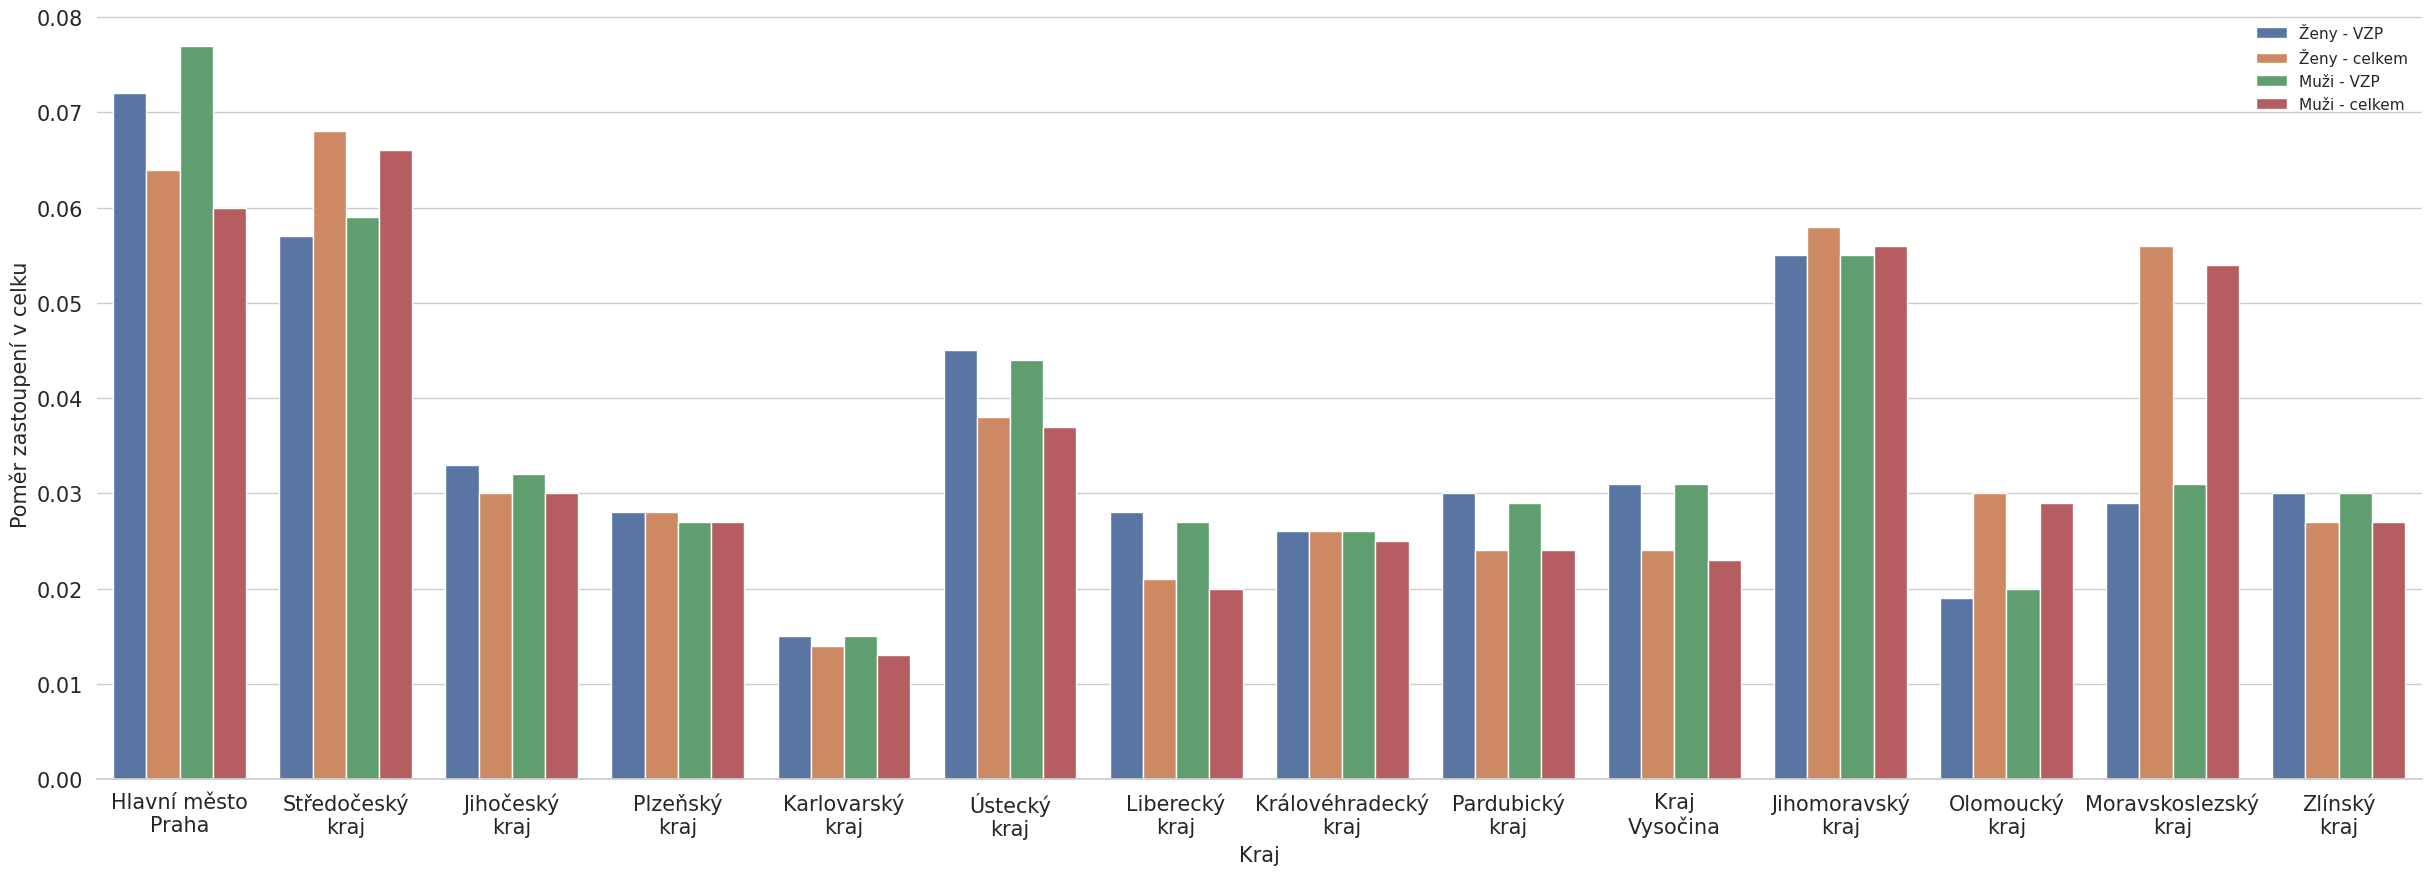

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(30,10)})
sns.set_style("whitegrid")

sns.barplot(data=total_demo2, x="area_parsed", y="ratio_total", hue="label")

sns.despine(left = True)

# plt.title(title, fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Kraj', fontsize=15)
plt.ylabel('Poměr zastoupení v celku', fontsize=15)
plt.legend(frameon=False)
plt.show();


### 2.2.2 Age comparison

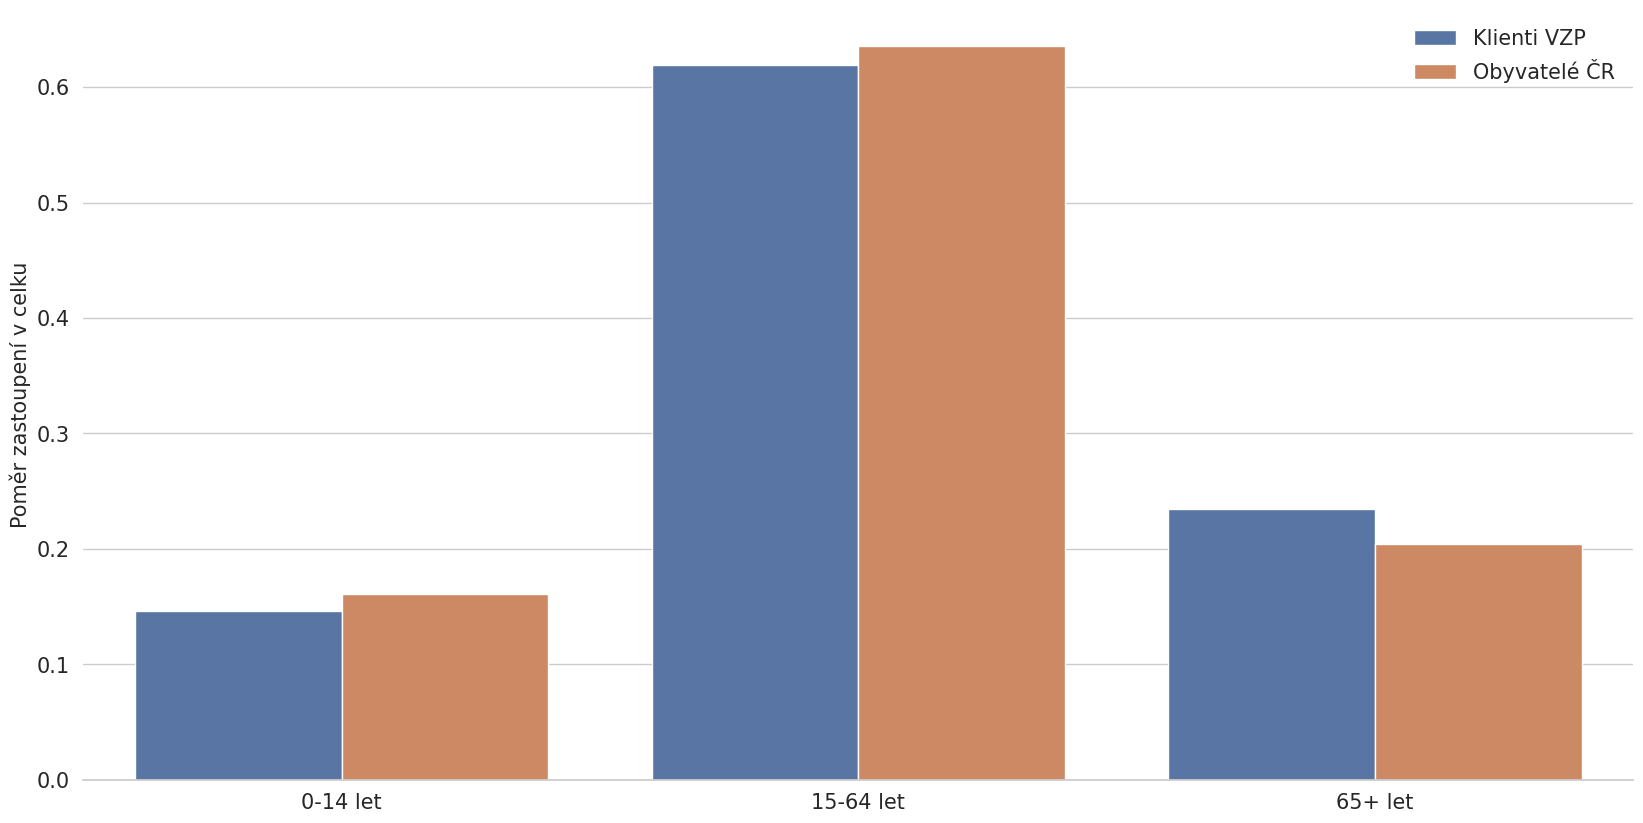

In [73]:
vzp_u14 = vzp_age[:3]
vzp_u14_ratio = vzp_u14.ratio.sum()

vzp_o65 = vzp_age[13:-1]
vzp_o65_ratio = vzp_o65.ratio.sum()

vzp_med = vzp_age[3:13]
vzp_med_ratio = vzp_med.ratio.sum()


vzp_ages = pd.DataFrame([
            ['0-14 let',vzp_u14_ratio],
            ['15-64 let',vzp_med_ratio],
            ['65+ let', vzp_o65_ratio]], columns=['age_interval', 'ratio'])
            
vzp_ages['label'] = 'Klienti VZP'

demo_ages = pd.DataFrame([
                ['0-14 let', 1691760/10524167],
                ['15-64 let', 6684359/10524167],
                ['65+ let', 2148048/10524167]], columns=['age_interval', 'ratio'])

demo_ages['label'] = 'Obyvatelé ČR'



total_ages = pd.concat([vzp_ages, demo_ages])

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")

sns.barplot(data=total_ages, x="age_interval", y="ratio", hue="label")

sns.despine(left = True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('', fontsize=15)
plt.ylabel('Poměr zastoupení v celku', fontsize=15)
plt.legend(frameon=False, fontsize=15)
plt.show();


### 2.3 Observation
- from sections 2.1 and 2.2
- gender:
    - OZP: F 55:45 M ratio (50:50 until 30 y)
        - https://www.ozp.cz/web/files-c/510/vz_ozp_2011_working.pdf, https://www.ozp.cz/web/files-c/510/vz_ozp_2010_working.pdf
    - VZP: F 50:50 M (46:54 between 30-55 y)
        - see rocenka_vzp_2021.xlsx

- age:
    - OZP has younger customers compare to VZP until 45 y (by ratios)
        - see table in section 2.1 (column difference)

- demographics:
    - VZP: customers corresponds to Czech demographics
    - OZP: no data

- comparison:
    - VZP has 7.99x more clients than OZP

    - VZP must have paid x more expertises than OZP in following years: 
    
|   year |     count |
|-------:|----------:|
|   2011 |   1.37778 |
|   2012 |   8.0901  |
|   2013 |   8.044   |
|   2014 |   7.75978 |
|   2015 |   7.89288 |
|   2016 |   7.95031 |
|   2017 |   7.97112 |
|   2018 |   7.9794  |
|   2019 |   7.92366 |
|   2020 |   7.84516 |
|   2021 | nan       |

### 2.4 VZP estimate

In [14]:
insurances = pd.read_csv(PATH_FINAL+'insurances.csv', index_col=0)
ozp = insurances[insurances.insurance_company == 'OZP']
vzp = insurances[insurances.insurance_company == 'VZP']

In [462]:
# num of clients = https://www.mzcr.cz/wp-content/uploads/2013/07/zakladni_ukazatele.pdf
vzp_clients = 5_922_131
ozp_clients = 740_817
clients_ratio = vzp_clients / ozp_clients

vzp_expertises = vzp[['count', 'year']].groupby('year').sum()
ozp_expertises = ozp[['count', 'year']].groupby('year').sum()
expertises_ratio = vzp_expertises / ozp_expertises

print(f'VZP has {round(clients_ratio, 2)}x more clients than OZP')
print(f'VZP must have paid x more expertises than OZP: ')
expertises_ratio


VZP has 7.99x more clients than OZP
VZP must have paid x more expertises than OZP: 


,count
year,
2011,1.377778
2012,8.090096
2013,8.043998
2014,7.759779
2015,7.892878
2016,7.950314
2017,7.971118
2018,7.979401
2019,7.923656


In [424]:
nrpzs = pd.read_csv(PATH_FINAL+'nrpzs.csv', index_col=0)
nrpzs = nrpzs[['ico', 'lat', 'lng', 'okres_code', 'okres', 'kraj', 'kraj_code']]

# number of branches
ico_count = nrpzs.ico.value_counts().reset_index()
ico_count.columns = ['ico', 'ico_count']

nrpzs = pd.merge(nrpzs, ico_count)

In [425]:
ozp_nrpzs = pd.merge(ozp, nrpzs)
print(f'Merged {ozp_nrpzs.ico.nunique()} out of {nrpzs.ico.nunique()}. {round(100*ozp_nrpzs.ico.nunique()/nrpzs.ico.nunique(), 2)} %')
ozp_nrpzs['count_per_branch'] = (ozp_nrpzs['count'] / ozp_nrpzs['ico_count']).apply(round)
ozp_nrpzs


Merged 17363 out of 26198. 66.28 %


,count,expertise_code,ico,insurance_company,procedure_code,region,year,expertise_name,lat,lng,okres_code,okres,kraj,kraj_code,ico_count,count_per_branch
0,170,1,67011080.0,OZP,NaN,NaN,2015,praktické lékařství pro dospělé,49.559612,16.419349,CZ0641,Blansko,Jihomoravský kraj,CZ064,1,170
1,164,1,67011080.0,OZP,NaN,NaN,2016,praktické lékařství pro dospělé,49.559612,16.419349,CZ0641,Blansko,Jihomoravský kraj,CZ064,1,164
2,176,1,67011080.0,OZP,NaN,NaN,2018,praktické lékařství pro dospělé,49.559612,16.419349,CZ0641,Blansko,Jihomoravský kraj,CZ064,1,176
3,166,1,67011080.0,OZP,NaN,NaN,2019,praktické lékařství pro dospělé,49.559612,16.419349,CZ0641,Blansko,Jihomoravský kraj,CZ064,1,166
4,206,1,67011080.0,OZP,NaN,NaN,2017,praktické lékařství pro dospělé,49.559612,16.419349,CZ0641,Blansko,Jihomoravský kraj,CZ064,1,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552478,868,921,49158350.0,OZP,NaN,NaN,2011,porodní asistentka,49.256254,17.756169,CZ0724,Zlín,Zlínský kraj,CZ072,1,868
552479,165,921,49158350.0,OZP,NaN,NaN,2018,porodní asistentka,49.256254,17.756169,CZ0724,Zlín,Zlínský kraj,CZ072,1,165
552480,132,921,49158350.0,OZP,NaN,NaN,2016,porodní asistentka,49.256254,17.756169,CZ0724,Zlín,Zlínský kraj,CZ072,1,132
552481,724,921,1671693.0,OZP,NaN,NaN,2020,porodní asistentka,49.321298,14.643427,CZ0317,Tábor,Jihočeský kraj,CZ031,1,724


In [535]:
# kraj x okres
district_area = ozp_nrpzs[['okres', 'kraj']].drop_duplicates()
district_area.columns = ['district', 'area']

# kody vykonu
expertises = ozp[['expertise_code', 'expertise_name']].drop_duplicates()
expertises.expertise_code = expertises.expertise_code.apply(lambda n:f'{n:>03}').astype(str)
expertises = expertises.sort_values('expertise_code')
expertises


In [590]:
# see https://drive.google.com/drive/u/0/folders/1fGGfafSeFU_fdP3SqnFyHJ00VS52GVhU
regions = {
    'Hlavní město Praha' : 'Čechy',
    'Středočeský kraj' : 'Čechy',
    'Jihočeský kraj' : 'Čechy',
    'Plzeňský kraj' : 'Čechy',
    'Karlovarský kraj' : 'Čechy',
    'Ústecký kraj' : 'Čechy',
    'Liberecký kraj' : 'Čechy',
    'Královéhradecký kraj' : 'Čechy',
    'Pardubický kraj' : 'Čechy',
    'Kraj Vysočina' : 'Morava',
    'Jihomoravský kraj' : 'Morava',
    'Olomoucký kraj' : 'Slezsko',
    'Zlínský kraj' : 'Slezsko',
    'Moravskoslezský kraj' : 'Slezsko',
}

# okresy
ozp_district_counts = ozp_nrpzs[['okres', 'year', 'expertise_code', 'count_per_branch']].groupby(['okres', 'year', 'expertise_code']).sum().reset_index()
ozp_district_counts.columns = ['district', 'year', 'expertise_code', 'count']
ozp_district_counts = pd.merge(ozp_district_counts, district_area)

# kraje
ozp_area_counts = ozp_nrpzs[['kraj', 'year', 'expertise_code', 'count_per_branch']].groupby(['kraj', 'year', 'expertise_code']).sum().reset_index()
ozp_area_counts.columns = ['area', 'year', 'expertise_code', 'count']
ozp_area_counts['region'] = ozp_area_counts['area'].apply(lambda x: regions[x])

# zeme
ozp_region_counts = ozp_area_counts[['region', 'year', 'expertise_code', 'count']].groupby(['region', 'year', 'expertise_code']).sum().reset_index()
ozp_region_counts.columns = ['region', 'year', 'expertise_code', 'count']

ozp_area_counts = pd.merge(ozp_area_counts, ozp_region_counts, on=['region', 'year', 'expertise_code'], suffixes=('', '_total'))
# ozp_area_counts['count_ratio'] = ozp_area_counts['count'] / ozp_area_counts['count_total']

ozp_district_counts = pd.merge(ozp_district_counts, ozp_area_counts, on=['area', 'year', 'expertise_code'], suffixes=('', '_area'))
ozp_district_counts['ratio_area'] = ozp_district_counts['count'] / ozp_district_counts['count_area']
ozp_district_counts['ratio_total'] = ozp_district_counts['count'] / ozp_district_counts['count_total']

In [636]:
vzp_expertises_count = vzp[['count', 'year', 'region', 'expertise_code']].groupby(['year', 'region', 'expertise_code']).sum().reset_index()
vzp_exp = pd.merge(vzp, vzp_expertises_count, on=['year', 'expertise_code'], suffixes=('_procedure', ''))
vzp_exp = vzp_exp.drop_duplicates(['expertise_code', 'year', 'region'])

In [564]:
# kolikrat vice ceho a v jakem regionu
vzp_region_counts = vzp_exp[['count', 'expertise_code', 'region', 'year']]
region_counts = pd.merge(vzp_region_counts, ozp_region_counts, on=['region', 'expertise_code', 'year'], suffixes=['_vzp', '_ozp'])
region_counts['ratio'] = region_counts['count_vzp'] / region_counts['count_ozp']
region_counts

,count_vzp,expertise_code,region,year,count_ozp,ratio
0,247966,1,Morava,2011,109206,2.270626
1,286752,1,Slezsko,2011,45761,6.266297
2,1078845,1,Čechy,2011,462892,2.330662
3,1449250,1,Morava,2012,86472,16.759760
4,1659710,1,Slezsko,2012,52597,31.555222
...,...,...,...,...,...,...
5308,673,307,Čechy,2015,116,5.801724
5309,641,307,Čechy,2016,112,5.723214
5310,349,307,Čechy,2017,160,2.181250
5311,421,307,Čechy,2018,100,4.210000


In [644]:
## compute customers in area to region ratio
total_demo['region'] = total_demo['area'].apply(lambda x: regions.get(x, np.nan))
vzp_region_customer = total_demo[['count_vzp', 'region']].groupby('region').sum().reset_index()
total_demo = pd.merge(total_demo, vzp_region_customer, on=['region'], suffixes=('', '_region'))
total_demo['ratio_area'] = total_demo['count_vzp'] / total_demo['count_vzp_region']

,area,region,ratio_area
10,Jihomoravský kraj,Morava,0.640705
9,Kraj Vysočina,Morava,0.359295
13,Moravskoslezský kraj,Slezsko,0.377907
11,Olomoucký kraj,Slezsko,0.246107
12,Zlínský kraj,Slezsko,0.375986
0,Hlavní město Praha,Čechy,0.222687
2,Jihočeský kraj,Čechy,0.0962286
4,Karlovarský kraj,Čechy,0.0449934
7,Královéhradecký kraj,Čechy,0.0782965
6,Liberecký kraj,Čechy,0.081177


In [673]:
## slozeni VZP pojistencu
tmp = total_demo[['area', 'region', 'count']].groupby(['region']).sum().reset_index()

tmp = pd.merge(total_demo[['area', 'region', 'count']], tmp, on='region', suffixes=('', '_region'))
tmp['region_ratio'] = tmp['count'] / tmp['count_region']
tmp[['region', 'area', 'region_ratio']].sort_values(['region', 'area'])

,region,area,region_ratio
10,Morava,Jihomoravský kraj,0.706449
9,Morava,Kraj Vysočina,0.293551
13,Slezsko,Moravskoslezský kraj,0.495467
11,Slezsko,Olomoucký kraj,0.264081
12,Slezsko,Zlínský kraj,0.240452
0,Čechy,Hlavní město Praha,0.200780
2,Čechy,Jihočeský kraj,0.097472
4,Čechy,Karlovarský kraj,0.043059
7,Čechy,Královéhradecký kraj,0.083047
6,Čechy,Liberecký kraj,0.067144


In [688]:
# total_demo[['area', 'region', 'ratio_area']].sort_values(['region', 'area'])

,area,region,ratio_area
10,Jihomoravský kraj,Morava,0.640705
9,Kraj Vysočina,Morava,0.359295
13,Moravskoslezský kraj,Slezsko,0.377907
11,Olomoucký kraj,Slezsko,0.246107
12,Zlínský kraj,Slezsko,0.375986
0,Hlavní město Praha,Čechy,0.222687
2,Jihočeský kraj,Čechy,0.0962286
4,Karlovarský kraj,Čechy,0.0449934
7,Královéhradecký kraj,Čechy,0.0782965
6,Liberecký kraj,Čechy,0.081177


In [675]:
ozp_area_ratio21.sort_values(['region', 'area'])

,area,year,ratio_area,region
1,Jihomoravský kraj,2021,0.782762,Morava
4,Kraj Vysočina,2021,0.217238,Morava
7,Moravskoslezský kraj,2021,0.463170,Slezsko
8,Olomoucký kraj,2021,0.323065,Slezsko
12,Zlínský kraj,2021,0.213765,Slezsko
0,Hlavní město Praha,2021,0.490159,Čechy
2,Jihočeský kraj,2021,0.061244,Čechy
3,Karlovarský kraj,2021,0.025959,Čechy
5,Královéhradecký kraj,2021,0.042166,Čechy
6,Liberecký kraj,2021,0.032793,Čechy


In [639]:
## vykony OZP na kraje po rocich - pomery

ozp_area_ratio = ozp_district_counts[['area', 'region', 'year', 'count']].drop_duplicates()
ozp_area_ratio = ozp_area_ratio.groupby(['area', 'region', 'year']).sum().reset_index()
## compute customers in area to region ratio
vzp_region_expertise = ozp_area_ratio[['count', 'region', 'year']].groupby(['region', 'year']).sum().reset_index()
ozp_area_ratio = pd.merge(ozp_area_ratio, vzp_region_expertise, on=['region', 'year'], suffixes=('', '_region'))
ozp_area_ratio['ratio_area'] = ozp_area_ratio['count'] / ozp_area_ratio['count_region']
ozp_area_ratio = ozp_area_ratio[['area', 'region', 'year', 'ratio_area']].sort_values(['region', 'area'])
ozp_area_ratio21 = ozp_area_ratio.groupby(['area']).mean().reset_index()
ozp_area_ratio21['year'] = 2021
ozp_area_ratio21['region'] = ozp_area_ratio21['area'].apply(lambda x: regions[x])
ozp_area_ratio = pd.concat([ozp_area_ratio, ozp_area_ratio21])
ozp_area_ratio

,area,region,year,ratio_area
90,Jihomoravský kraj,Morava,2011,0.799449
92,Jihomoravský kraj,Morava,2012,0.796152
94,Jihomoravský kraj,Morava,2013,0.791171
96,Jihomoravský kraj,Morava,2014,0.785767
98,Jihomoravský kraj,Morava,2015,0.784364
...,...,...,...,...
9,Pardubický kraj,Čechy,2021,0.033340
10,Plzeňský kraj,Čechy,2021,0.076174
11,Středočeský kraj,Čechy,2021,0.158660
12,Zlínský kraj,Slezsko,2021,0.213765


In [641]:
# rozdeleni vzp podle oblasti
vzp_exp_area = vzp_exp[['region', 'expertise_code', 'year', 'count']].drop_duplicates()
vzp_exp_area = pd.merge(vzp_exp_area, ozp_area_ratio)
vzp_exp_area['count_area'] = (vzp_exp_area['count'] * vzp_exp_area['ratio_area']).apply(round)
vzp_exp_area

,region,expertise_code,year,count,area,ratio_area,count_area
0,Morava,1,2011,247966,Jihomoravský kraj,0.799449,198236
1,Morava,1,2011,247966,Kraj Vysočina,0.200551,49730
2,Morava,902,2011,665398,Jihomoravský kraj,0.799449,531952
3,Morava,902,2011,665398,Kraj Vysočina,0.200551,133446
4,Morava,14,2011,616833,Jihomoravský kraj,0.799449,493127
...,...,...,...,...,...,...,...
31756,Čechy,922,2021,1400,Liberecký kraj,0.032793,46
31757,Čechy,922,2021,1400,Pardubický kraj,0.033340,47
31758,Čechy,922,2021,1400,Plzeňský kraj,0.076174,107
31759,Čechy,922,2021,1400,Středočeský kraj,0.158660,222


In [719]:
vzp_exp_district = pd.merge(vzp_exp_area, ozp_district_counts[['district', 'expertise_code', 'area', 'year', 'ratio_area']], on=['expertise_code', 'area', 'year'], suffixes=('', '_district'))
vzp_exp_district['count_district'] = (vzp_exp_district['count_area']* vzp_exp_district['ratio_area_district']).apply(round)
vzp_exp_district

,region,expertise_code,year,count,area,ratio_area,count_area,district,ratio_area_district,count_district
0,Morava,1,2011,247966,Jihomoravský kraj,0.799449,198236,Blansko,0.004661,924
1,Morava,1,2011,247966,Jihomoravský kraj,0.799449,198236,Brno-město,0.180609,35803
2,Morava,1,2011,247966,Jihomoravský kraj,0.799449,198236,Brno-venkov,0.060069,11908
3,Morava,1,2011,247966,Jihomoravský kraj,0.799449,198236,Břeclav,0.031788,6301
4,Morava,1,2011,247966,Jihomoravský kraj,0.799449,198236,Hodonín,0.075430,14953
...,...,...,...,...,...,...,...,...,...,...
65397,Čechy,613,2020,10259,Ústecký kraj,0.086688,889,Ústí nad Labem,1.000000,889
65398,Čechy,703,2020,6637,Královéhradecký kraj,0.042639,283,Hradec Králové,1.000000,283
65399,Čechy,703,2020,6637,Pardubický kraj,0.038673,257,Pardubice,1.000000,257
65400,Čechy,6I3,2020,2019,Středočeský kraj,0.168229,340,Mělník,0.666667,227


## 3. Top procedures (VZP)

In [738]:
mf_set = set()
most_frequent = vzp[['year', 'expertise_code', 'procedure_code', 'count']].groupby(['year', 'expertise_code', 'procedure_code']).sum().reset_index().sort_values('count', ascending=False)

for year in most_frequent.year.unique():
    print(f'Rok: {year}')
    best = most_frequent[most_frequent.year == year].head()
    display(best)
    print('---'*10)
    mf_set.update(best.procedure_code.unique())

Rok: 2020


,year,expertise_code,procedure_code,count
75902,2020,913,6613.0,26517222
67771,2020,1,1543.0,11902738
74839,2020,801,97111.0,11443589
75917,2020,913,6649.0,7327684
75903,2020,913,6620.0,7186321


------------------------------
Rok: 2019


,year,expertise_code,procedure_code,count
67634,2019,913,6613.0,25468423
66566,2019,801,97111.0,12682260
59670,2019,1,9543.0,9221501
67647,2019,913,6649.0,6999475
60185,2019,902,21113.0,6652361


------------------------------
Rok: 2018


,year,expertise_code,procedure_code,count
59500,2018,913,6613.0,23118451
58414,2018,801,97111.0,12555277
51866,2018,1,9543.0,8960491
52345,2018,902,21113.0,6673001
59512,2018,913,6649.0,6498778


------------------------------
Rok: 2021


,year,expertise_code,procedure_code,count
83896,2021,913,6613.0,22521789
82830,2021,801,97111.0,10211979
83897,2021,913,6620.0,9287231
76060,2021,1,1543.0,8256931
83912,2021,913,6649.0,6158671


------------------------------
Rok: 2017


,year,expertise_code,procedure_code,count
51695,2017,913,6613.0,21659396
50614,2017,801,97111.0,12316093
44088,2017,1,9543.0,8705955
44554,2017,902,21113.0,6836312
51707,2017,913,6649.0,6106702


------------------------------
Rok: 2016


,year,expertise_code,procedure_code,count
43919,2016,913,6613.0,20275525
42835,2016,801,97111.0,12429691
36247,2016,1,9543.0,8480915
36722,2016,902,21113.0,7149478
43931,2016,913,6649.0,5616603


------------------------------
Rok: 2015


,year,expertise_code,procedure_code,count
36080,2015,913,6613.0,19217419
34987,2015,801,97111.0,12233019
28353,2015,1,9543.0,8115158
28836,2015,902,21113.0,7204733
36092,2015,913,6649.0,5337924


------------------------------
Rok: 2012


,year,expertise_code,procedure_code,count
12547,2012,913,6613.0,18049203
11361,2012,801,97111.0,12238723
5149,2012,902,21113.0,7138099
5159,2012,902,21225.0,5612613
12559,2012,913,6649.0,4901549


------------------------------
Rok: 2014


,year,expertise_code,procedure_code,count
28197,2014,913,6613.0,17768607
27108,2014,801,97111.0,11998044
21044,2014,902,21113.0,7256245
21054,2014,902,21225.0,5136936
28209,2014,913,6649.0,4859605


------------------------------
Rok: 2013


,year,expertise_code,procedure_code,count
20404,2013,913,6613.0,17493684
19253,2013,801,97111.0,12027057
13187,2013,902,21113.0,7140380
13197,2013,902,21225.0,5212651
20416,2013,913,6649.0,4743996


------------------------------
Rok: 2011


,year,expertise_code,procedure_code,count
4515,2011,913,6613.0,2892040
4517,2011,913,6623.0,2009842
3663,2011,801,97111.0,2002066
375,2011,902,21113.0,1199410
385,2011,902,21225.0,913939


------------------------------


- 01543 999 (VZP) EPIZODA PÉČE/KONTAKT V SOUVISLOSTI S KLINICKÝM VYŠETŘENÍM V ORDINACI LÉKAŘE PRIMÁRNÍ PÉČE
Výkon se vykazuje společně s výkonem klinického vyšetření při návštěvě u
všeobecného praktického lékaře, praktického lékaře pro děti a dorost a u
ambulantního gynekologa a při návštěvní službě poskytnuté všeobecným
praktickým lékařem a praktickým...

- 06613 913 OŠETŘOVATELSKÁ INTERVENCE
Výkon lze vykázat po předchozí indikaci ošetřujícího lékaře. Možnost
opakování výkonu, maximálně však 3 hodiny/den. Výkon lze kombinovat s
ostatními materiálovými výkony odbornosti 913.

- 06620 913 APLIKACE LÉKŮ NEINVAZIVNÍ CESTOU
Provedení aplikace léčiv per os, aplikace léku do spojivkového vaku. Výkon
lze vykázat po předchozí indikaci ošetřujícího lékaře, která může být
jednorázová nebo vyjadřující konkrétní frekvenci výkonů na určité období, u
klientů, kterým zdravotní nebo...

- 06623 913 APLIKACE LÉČEBNÉ TERAPIE I. M. NEBO S. C.
Výkon lze vykázat po předchozí indikaci ošetřujícícho lékaře, která může být
jednorázová nebo vyjadřující konkrétní frekvenci výkonů na určité období,
jen materiálové náklady výkonu. Přičti k výkonu ošetřovatelská intervence.
Aplikaci I. M. injekce...

- 06649 913 BONIFIKAČNÍ VÝKON ZA PRÁCI V DOBĚ PRACOVNÍHO VOLNA NEBO PRACOVNÍHO KLIDU 

- 09543 999 SIGNÁLNÍ VÝKON KLINICKÉHO VYŠETŘENÍ / DO 31.12.2014: REGULAČNÍ POPLATEK ZA NÁVŠTĚVU -- POPLATEK UHRAZEN
Vykazuje se u všech věkových kategorií s výkonem klinického vyšetření
provedeným pojištěnci při návštěvě klinického psychologa a klinického
logopeda a dále s výkonem klinického vyšetření provedeným pojištěnci
staršímu 18 let při návštěvě u praktickéh

- 21113 902 AOD FYZIKÁLNÍ TERAPIE II
Galvanizace, iontoforéza, diadynamik, aplikace středofrekvenčních proudů
(IF), ultrazvuk, magnetoterapie, podtlakové přístroje,intermitentní
přístrojová komprese, přístrojové trakce, transkutánní elektrická nervová
stimulace (TENS),parafinová lázeň,..

- 21225 902 INDIVIDUÁLNÍ KINEZIOTERAPIE II. / DO 31. 12. 2018 LÉČEBNÁ TĚLESNÁ VÝCHOVA INDIVIDUÁLNÍ - KONDIČNÍ A ANALYTICKÉ METODY
Individuální pohybová terapie využívající obecné principy a metody k
odstranění poruch v pohybovém systému. Výkon zahrne metody ke zvýšení
svalové síly, zvětšení rozsahu pohybu, k reedukaci pohybových stereotypů,
nebo metody respirační fyzioterapie...

- 97111 819 SEPARACE SÉRA NEBO PLAZMY Práce spojené se získáním séra (plazmy) v laboratoři.

In [ ]:
# stomatologie
dentists_expertise = insurances[insurances.expertise_code == 14][['year', 'expertise_code', 'count']].groupby(['year', 'expertise_code']).sum().reset_index().sort_values('count', ascending=False)
dentists_expertise.sort_values('year')

,year,expertise_code,count
0,2011,14,3563421
1,2012,14,20798456
2,2013,14,20613845
3,2014,14,20529569
4,2015,14,23104704
5,2016,14,23218850
6,2017,14,23230133
7,2018,14,23558507
8,2019,14,23847946
9,2020,14,21697894


In [741]:
# ct hlavy
ct_head = insurances[insurances.procedure_code == 89611][['year', 'procedure_code', 'count']].groupby(['year', 'procedure_code']).sum().reset_index().sort_values('count', ascending=False)
ct_head.sort_values('year')

,year,procedure_code,count
0,2011,89611.0,30548
1,2012,89611.0,198478
2,2013,89611.0,204587
3,2014,89611.0,207000
4,2015,89611.0,213204
5,2016,89611.0,222186
6,2017,89611.0,228393
7,2018,89611.0,235020
8,2019,89611.0,244528
9,2020,89611.0,242071


In [747]:
# zlomenina 
rupture = insurances[insurances.expertise_code.isin(['523', '503'])][['year', 'expertise_code', 'count']].groupby(['year', 'expertise_code']).sum().reset_index().sort_values('count', ascending=False)
rupture.sort_values('year')

,year,expertise_code,count
0,2011,503,135374
1,2012,503,559826
2,2013,503,598765
3,2014,503,603204
4,2015,503,737780
5,2016,503,751848
6,2017,503,744563
7,2018,503,809958
8,2019,503,830949
9,2020,503,830218


In [765]:
# angioplastika
# only 810 x 89423
angio = insurances[insurances.procedure_code.isin([89435, 89437, 54510, 89423]) & insurances.expertise_code.isin(['117', '534', '810'])][['year','count']].groupby(['year']).sum().reset_index().sort_values('count', ascending=False)
angio.sort_values('year')

,year,count
0,2017,803
1,2018,835
2,2019,814
3,2020,489
4,2021,404


In [754]:
# infarkt
# NEODKLADNÁ PÉČE POSKYTOVANÁ LÉKAŘEM Á 10 MINUT Řešení akutních příhod v terénu (v ambulanci či při výjezdu). Jedná se o akutní stavy nejrůznější etiologie (mimo výkony kardiopulmonální resuscitace), které vyžadují urgentní řešení, např. astmatický záchvat, infarkt myokarduEODKLADNÁ PÉČE POSKYTOVANÁ LÉKAŘEM Á 10 MINUT Řešení akutních příhod v terénu (v ambulanci či při výjezdu). Jedná se o akutní stavy nejrůznější etiologie (mimo výkony kardiopulmonální resuscitace), které vyžadují urgentní řešení, např. astmatický záchvat, infarkt myokardu
heart_attack = insurances[insurances.procedure_code == 9211][['year', 'procedure_code', 'count']].groupby(['year', 'procedure_code']).sum().reset_index().sort_values('count', ascending=False)
heart_attack.sort_values('year')


,year,expertise_code,count
0,2011,505,5466
1,2012,505,18160
2,2013,505,15345
3,2014,505,14499
4,2015,505,16870
5,2016,505,16984
6,2017,505,14565
7,2018,505,13853
8,2019,505,13008
9,2020,505,12705


In [766]:
# kardiologie
cardio = insurances[insurances.expertise_code == '505'][['year', 'expertise_code', 'count']].groupby(['year', 'expertise_code']).sum().reset_index().sort_values('count', ascending=False)
cardio.sort_values('year')

,year,expertise_code,count
0,2011,505,5466
1,2012,505,18160
2,2013,505,15345
3,2014,505,14499
4,2015,505,16870
5,2016,505,16984
6,2017,505,14565
7,2018,505,13853
8,2019,505,13008
9,2020,505,12705


In [ ]:
# https://www.vzp.cz/poskytovatele/ciselniky/zdravotni-vykony
# https://media.vzpstatic.cz/media/Default/dokumenty/ciselniky/vykony_01348.pdf
# https://media.vzpstatic.cz/media/Default/dokumenty/ciselniky/vykony_01389.pdf

## 4. Smlouvy pojistoven se zubari

In [52]:
dent_wp = doctors.reset_index()[['workplace_url', 'IC']].drop_duplicates('workplace_url')#.dropna()
dent_wp = dent_wp[~dent_wp.workplace_url.isna()]
print(f'Počet zubních zdrav. zařízení: {dent_wp.shape[0]}')
print(f'Bez pojistovny: {dent_wp[dent_wp.IC.isna()].shape[0]}')
print(f'Procento: {dent_wp[dent_wp.IC.isna()].shape[0]/dent_wp.shape[0]}')
print(f'Pojistovna VZP: {dent_wp[(~dent_wp.IC.isna()) &dent_wp.IC.str.contains("VZP")].shape[0]}')

Počet zubních zdrav. zařízení: 6159
Bez pojistovny: 4800
Procento: 0.7793472966390648
Pojistovna VZP: 1339


In [3]:
5914857/10524167

0.5620261442069476